# GCN Node Classification on Karate Club Data - NumPy

In [42]:
# importing the required libraries
import numpy as np
from scipy.linalg import sqrtm 
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

## Zachary's Karate Club Data

In [2]:
# helper function to display the graph
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(5, 5))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))
    nx.draw(nx_G, pos, with_labels=label_map is not None, labels=label_map, node_color=node_color, ax=ax, **kwargs)

In [3]:
# Zachary's Karate Club graph
g = nx.karate_club_graph()

In [4]:
# number of nodes and edges
g.number_of_nodes(), g.number_of_edges()

(34, 78)

In [5]:
# community structure or the class of each node
# note: there are three classes
communities = greedy_modularity_communities(g)
print(communities)

[frozenset({8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}), frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21}), frozenset({0, 16, 19, 4, 5, 6, 10, 11})]


In [6]:
# making a color map for bettwe visualization
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0] # getting the number of classes
labels = np.eye(n_classes)[colors.astype(int)] # creating one-hot encoding for the labels

print(n_classes)
print(labels[:5]) # visualizing the first five labels

3
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [7]:
# getting the club labels
club_labels = nx.get_node_attributes(g,'club')
print(club_labels)

{0: 'Mr. Hi', 1: 'Mr. Hi', 2: 'Mr. Hi', 3: 'Mr. Hi', 4: 'Mr. Hi', 5: 'Mr. Hi', 6: 'Mr. Hi', 7: 'Mr. Hi', 8: 'Mr. Hi', 9: 'Officer', 10: 'Mr. Hi', 11: 'Mr. Hi', 12: 'Mr. Hi', 13: 'Mr. Hi', 14: 'Officer', 15: 'Officer', 16: 'Mr. Hi', 17: 'Mr. Hi', 18: 'Officer', 19: 'Mr. Hi', 20: 'Officer', 21: 'Mr. Hi', 22: 'Officer', 23: 'Officer', 24: 'Officer', 25: 'Officer', 26: 'Officer', 27: 'Officer', 28: 'Officer', 29: 'Officer', 30: 'Officer', 31: 'Officer', 32: 'Officer', 33: 'Officer'}


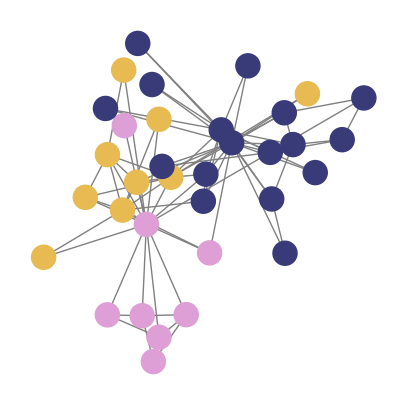

In [8]:
_ = draw_kkl(g, None, colors, cmap='tab20b', edge_color='gray')

In [9]:
A = nx.to_numpy_array(g) # adjacency matrix
print(A)

[[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]


### Making the normalized Adjacency Matrix

When we multiply the feacture vector with adjacency matrix, the zeros of the non connected nodes cancel the contribution of all non-connected nodes, resulting in an aggrigation of only the connected nodes, which results a graph neighborhood mask.


![image](_images_/img-1.png)

The original paper on GCN presented a normalized form of Adjacency matrix, which is used in the following way:
$$\hat{A} = \tilde{D}^{-0.5}\tilde{A}\tilde{D}^{-0.5} $$
where,
$\tilde{A} = A + I$, this adds self loop to the graph.
$$\hat{A}_{i,j} = \frac{1}{\sqrt{\tilde{d_i}\tilde{d_j}}}\tilde{A}_{i,j}$$
where, $\tilde{d_i}$ and $\tilde{d_j}$ are the degree of the nodes i and j in the graph.

In [10]:
A_mod = A + np.eye(g.number_of_nodes()) # add self-connections

D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())

D_mod_invroot = np.linalg.inv(sqrtm(D_mod))

A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

In [11]:
A_hat.shape # shape of A_hat

(34, 34)

Since we do not have any node features, we will use an identity matrix. Using an identity matrix as input features will effectively map each node in the graph to a column in the first layer, resulting in fully learable node embeddings

In [12]:
X = np.eye(g.number_of_nodes())

In [13]:
X.shape # shape of X

(34, 34)

## Helper function for GCNs

Resource for handling matrices/vectors/dots/transposes when deriving gradient equations:  [Stanford CS224n Gradient Notes](https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf)

In [14]:
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]

def norm_diff(dW, dW_approx):
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))

class GradDescentOptim():
    """
        Helper function for flowing the gradiwnts down the layers during back-propagation.
    """
    def __init__(self, lr, wd):
        self.lr = lr
        self.wd = wd
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.bs = None
        self.train_nodes = None
        
    def __call__(self, y_pred, y_true, train_nodes=None):
        self.y_pred = y_pred
        self.y_true = y_true
        
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
            
        self.bs = self.train_nodes.shape[0]
        
    @property
    def out(self):
        return self._out
    
    @out.setter
    def out(self, y):
        self._out = y

## GCN code in NumPy

The GCN Equation is given as 
$$H^{l+1} = \sigma(W\hat{A}H^{l})$$
where $H^{l}$ is the node embedding at layer $l$, $W$ is the weight matrix, $\hat{A}$ is the normalized adjacency matrix, and $\sigma$ is the activation function. The forward method does the exact same thing.

The $\hat{A}$ multiplies with the incoming feature vector $H^{l}$, this does the message passing. This gets multipled with the learned weigths $W$. Then this applies a non-linear activation function.

In [15]:
class GCNLayer():
    def __init__(self, n_inputs, n_outputs, activation=None, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs) # learnable weights
        self.activation = activation
        self.name = name
        
    def __repr__(self):
        return f"GCN: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
        
    def forward(self, A, X, W=None):
        """
        Assumes A is (bs, bs) adjacency matrix and X is (bs, D), where bs = "batch size" and D = input feature length.
        h is the hidden dimension.
        """
        self._A = A
        self._X = (A @ X).T # for calculating gradients. (D, bs)
        
        if W is None: 
            W = self.W
        
        H = W @ self._X     # (h, D)*(D, bs) -> (h, bs)

        if self.activation is not None:
            H = self.activation(H)

        self._H = H         # (h, bs)
        return self._H.T    # (bs, h)
    
    def backward(self, optim, update=True):
        """
            dtanh is the derivative of tanh activation function.
            d2 extracts the incoming gradients from the gradiant descent downstream and pass it to the activation function
        """
        dtanh = 1 - np.asarray(self._H.T)**2    # (bs, out_dim)
        d2 = np.multiply(optim.out, dtanh)      # (bs, out_dim) *element_wise* (bs, out_dim)
        
        self.grad = self._A @ d2 @ self.W       # (bs, bs)*(bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)     
        optim.out = self.grad
        
        dW = np.asarray(d2.T @ self._X.T) / optim.bs    # (out_dim, bs)*(bs, D) -> (out_dim, D)
        dW_wd = self.W * optim.wd / optim.bs            # weight decay update
        
        if update: # parameter update
            self.W -= (dW + dW_wd) * optim.lr 
        
        return dW + dW_wd
    
class SoftmaxLayer(): # its similar to a linear layer of Pytorch with softmax activation
    def __init__(self, n_inputs, n_outputs, name=''):
        self.n_inputs = n_inputs # input dimension
        self.n_outputs = n_outputs # output dimension
        self.W = glorot_init(self.n_outputs, self.n_inputs) # projection matrix
        self.b = np.zeros((self.n_outputs, 1)) # bias terms 
        self.name = name
        self._X = None # Used to calculate gradients
        
    def __repr__(self):
        return f"Softmax: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def shift(self, proj):
        """
            A trick of finding the Softmax by substracting the max for numericall stability.
        """
        shiftx = proj - np.max(proj, axis=0, keepdims=True)
        exps = np.exp(shiftx)
        return exps / np.sum(exps, axis=0, keepdims=True)
        
    def forward(self, X, W=None, b=None):
        """
            Compute the softmax of vector x in a numerically stable way. X is assumed to be (bs, h).
            The forward pass do not do any message passing, it just apply the layer to already computed embedding, 
            that are output from the GCN layer, and applies Softmax to it.
        """
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b

        proj = np.asarray(W @ self._X) + b # (out, h)*(h, bs) = (out, bs)
        return self.shift(proj).T # (bs, out)
    
    def backward(self, optim, update=True):
        # Should take in optimizer, update its own parameters and update the optimizer's "out"
        # A mask on loss to excludethe node that were not used for training
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))
        
        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optim.y_pred - optim.y_true)) # (bs, out_dim)
        d1 = np.multiply(d1, train_mask) # (bs, out_dim) with loss of non-train nodes set to zero
        
        self.grad = d1 @ self.W # (bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)
        optim.out = self.grad
        
        dW = (d1.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, in_dim) -> (out_dim, in_dim)
        db = d1.T.sum(axis=1, keepdims=True) / optim.bs # (out_dim, 1)
                
        dW_wd = self.W * optim.wd / optim.bs # L2 weight decay update
        
        if update: # standard backpropagation
            self.W -= (dW + dW_wd) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr
        
        return dW + dW_wd, db.reshape(self.b.shape)

The Model

In [29]:
class GCNNetwork():
    def __init__(self, n_inputs, n_outputs, n_layers, hidden_sizes, activation, seed=0):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        
        np.random.seed(seed)
        
        self.layers = list()
        # Input layer
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, name='in')
        self.layers.append(gcn_in)
        
        # Hidden layers
        for layer in range(n_layers):
            gcn = GCNLayer(self.layers[-1].W.shape[0], hidden_sizes[layer], activation, name=f'h{layer}')
            self.layers.append(gcn)
            
        # Output layer
        sm_out = SoftmaxLayer(hidden_sizes[-1], n_outputs, name='sm')
        self.layers.append(sm_out)
        
    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers])
    
    def embedding(self, A, X):
        # Loop through all GCN layers
        H = X
        for layer in self.layers[:-1]:
            H = layer.forward(A, H)
        return np.asarray(H)
    
    def forward(self, A, X):
        # GCN layers
        H = self.embedding(A, X)
        
        # Softmax
        p = self.layers[-1].forward(H)
        
        return np.asarray(p)

In [30]:
gcn_model = GCNNetwork(
    n_inputs=g.number_of_nodes(), 
    n_outputs=n_classes, 
    n_layers=2,
    hidden_sizes=[16, 2], 
    activation=np.tanh,
    seed=100,
)
gcn_model

GCN: W_in (34, 16)
GCN: W_h0 (16, 16)
GCN: W_h1 (16, 2)
Softmax: W_sm (2, 3)

In [31]:
y_pred = gcn_model.forward(A_hat, X)
embed = gcn_model.embedding(A_hat, X)
xent(y_pred, labels).mean()

1.0763527735684253

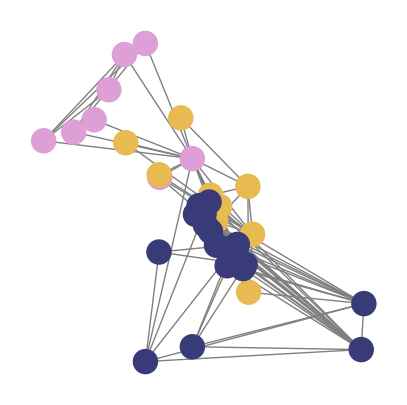

In [32]:
pos = {i: embed[i,:] for i in range(embed.shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='tab20b', edge_color='gray')

## Training and Results

In [33]:
train_nodes = np.array([0, 1, 8]) # taking one node from each class
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
opt2 = GradDescentOptim(lr=2e-2, wd=2.5e-2)

In [34]:
embeds = list()
accs = list()
train_losses = list()
test_losses = list()

loss_min = 1e6
es_iters = 0
es_steps = 50

for epoch in range(2000):
    
    y_pred = gcn_model.forward(A_hat, X)

    opt2(y_pred, labels, train_nodes)
    
    for layer in reversed(gcn_model.layers):
        layer.backward(opt2, update=True)
        
    embeds.append(gcn_model.embedding(A_hat, X))
    # Accuracy for non-training nodes
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
        [i for i in range(labels.shape[0]) if i not in train_nodes]
    ]
    accs.append(acc.mean())
    
    loss = xent(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1
        
    if es_iters > es_steps:
        print("Early stopping!")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")
        
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

Epoch: 1, Train Loss: 1.089, Test Loss: 1.075
Epoch: 101, Train Loss: 1.050, Test Loss: 1.043
Epoch: 201, Train Loss: 1.004, Test Loss: 0.995
Epoch: 301, Train Loss: 0.940, Test Loss: 0.922
Epoch: 401, Train Loss: 0.850, Test Loss: 0.817
Epoch: 501, Train Loss: 0.734, Test Loss: 0.690
Epoch: 601, Train Loss: 0.609, Test Loss: 0.571
Epoch: 701, Train Loss: 0.498, Test Loss: 0.484
Epoch: 801, Train Loss: 0.407, Test Loss: 0.424
Epoch: 901, Train Loss: 0.333, Test Loss: 0.381
Epoch: 1001, Train Loss: 0.273, Test Loss: 0.349
Epoch: 1101, Train Loss: 0.226, Test Loss: 0.325
Epoch: 1201, Train Loss: 0.191, Test Loss: 0.308
Epoch: 1301, Train Loss: 0.165, Test Loss: 0.295
Epoch: 1401, Train Loss: 0.145, Test Loss: 0.286
Epoch: 1501, Train Loss: 0.129, Test Loss: 0.280
Epoch: 1601, Train Loss: 0.117, Test Loss: 0.275
Epoch: 1701, Train Loss: 0.108, Test Loss: 0.272
Epoch: 1801, Train Loss: 0.100, Test Loss: 0.269
Epoch: 1901, Train Loss: 0.094, Test Loss: 0.267


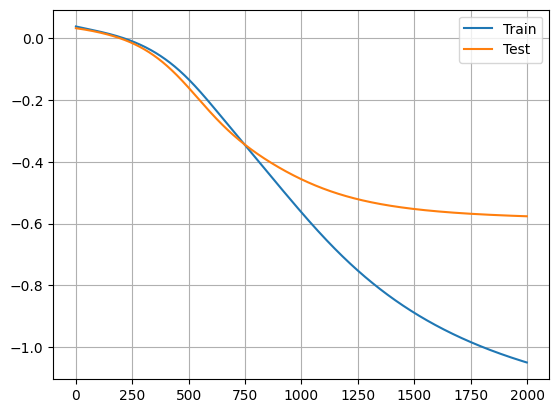

In [35]:
fig, ax = plt.subplots()
ax.plot(np.log10(train_losses), label='Train')
ax.plot(np.log10(test_losses), label='Test')
ax.legend()
ax.grid()

In [36]:
accs[-1]

0.9032258064516129

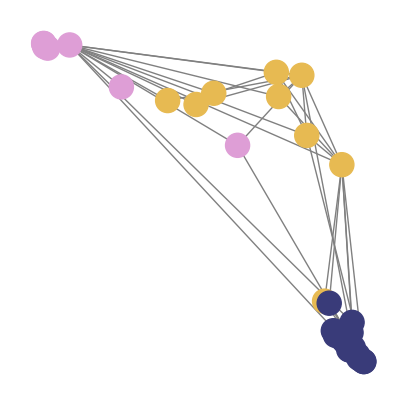

In [37]:
pos = {i: embeds[-1][i,:] for i in range(embeds[-1].shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='tab20b', edge_color='gray')

In [49]:
N = 500
snapshots = np.linspace(0, len(embeds)-1, N).astype(int)

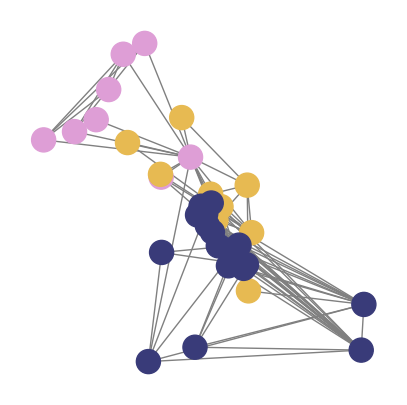

In [50]:
# Build plot
fig, ax = plt.subplots(figsize=(5, 5))
kwargs = {'cmap': 'tab20b', 'edge_color': 'gray', }#'node_size': 55}

def update(idx):
    ax.clear()
    embed = embeds[snapshots[idx]]
    pos = {i: embed[i,:] for i in range(embed.shape[0])}
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)

anim = animation.FuncAnimation(fig, update, frames=snapshots.shape[0], interval=10, repeat=False)

In [51]:
HTML(anim.to_html5_video())

In [54]:
anim.save('_images_/embed_anim.mp4')